In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json, os, math
import string
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
frequencies = json.load(open('../trained_weights/filtered_freq.json'))
max(frequencies.values()), math.log(4297431)

(4297431, 15.273527960263822)

In [3]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams.update({'font.size': 22})


[(0, 40), (1, 91), (2, 239), (3, 781), (4, 3368), (5, 12108), (6, 13544), (7, 8980), (8, 4688), (9, 1955), (10, 634), (11, 224), (12, 74), (13, 19), (14, 5), (15, 4)]


Text(0, 0.5, 'log of Number of Vocab words')

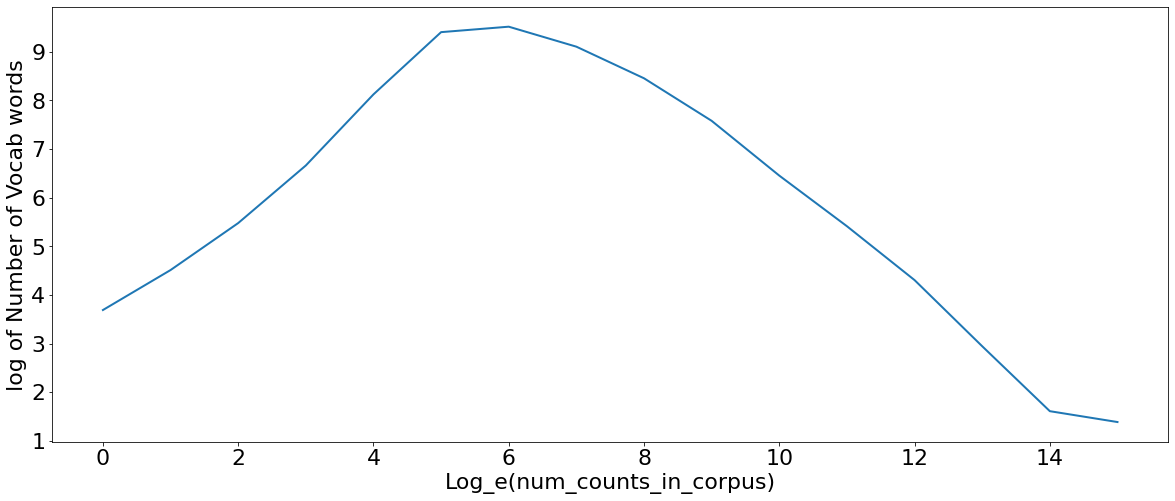

In [4]:
from collections import Counter
cntr = sorted(Counter([round(math.log(f)) for f in frequencies.values()]).items(), key = lambda x: x[0])
print(cntr)
x, y = [x[0] for x in cntr], [math.log(x[1]) for x in cntr]
plt.plot(x, y, linestyle='-', linewidth=2)
plt.xlabel("Log_e(num_counts_in_corpus)")
plt.ylabel("log of Number of Vocab words")

In [5]:
[(x) for x,y in list(frequencies.items()) if math.log(y) < 0.5]

['ĠSeym',
 'Vaults',
 'aditional',
 'hovah',
 'awaru',
 'vertisement',
 'Ġunbeliev',
 'Ġcumbers',
 'Ġunnecess',
 'Ġshenan',
 'Ġvolunte',
 'Ġdisadvant',
 'akeru',
 'irlf',
 'Ġbehavi',
 'ahime',
 'aterasu',
 'Ġteasp',
 'ĠMetatron',
 'arnaev',
 'ichick',
 'ĠShinra',
 'potion',
 'Ġmillenn',
 'Ġoun',
 'Buyable',
 'Ġhelicop',
 'govtrack',
 'Ġnewcom',
 'ĠLeban',
 'ĠNanto',
 'Ġhemor',
 'ĠKinnikuman',
 'iscons',
 'Ġwithd',
 'Redditor',
 'sbm',
 'ItemImage',
 'Ġencount',
 'Ġcontrace']

In [6]:
max_len = round(math.log(max(frequencies.values())))

In [7]:
def get_f1s(cm):
    p = [cm[i][i]/(0.00001+cm[i][i]+cm[i][i-1]) for i in range(2)]
    r = [cm[i][i]/(0.00001+cm[i][i]+cm[i-1][i]) for i in range(2)]
    return [2*pp*rr/(pp+rr+0.00001) for pp, rr in zip(p, r)]

In [8]:
def get_maj_f1(cm):
    return get_f1s([[cm[0][0]+cm[0][1], cm[1][0]+cm[1][1]], [0,0]])

In [9]:
def get_rand_f1(cm):
    return get_f1s([[(cm[0][0]+cm[0][1])//2, (cm[0][1]+cm[0][1])//2]]*2)

In [10]:
sum_ct = lambda x: x[0][0] + x[0][1] + x[1][0] + x[1][1]


In [11]:
pred_folders = ["savefolder/"+x for x in os.listdir("savefolder") if 'prd.gpt-j-6B' in x and x.split('.')[-2].endswith('0001')]
control_folders = ["savefolder/"+x for x in os.listdir("savefolder") if 'ctl.gpt-j-6B' in x and x.split('.')[-2].endswith('0001')]


In [12]:
this_f1, this_pos_f1, valid, control_f1, control_pos_f1, num_data, num_data_pos = [{c: 0
                                        for c in string.ascii_lowercase
                                    } for _ in range(7)]
tp_num, fp_num, fn_num, tn_num = [{c: {i: 0 for i in range(max_len)}
                        for c in string.ascii_lowercase} for _ in range(4)]
tp_eg, fp_eg, fn_eg, tn_eg = [{c: {i: [] for i in range(max_len)}
                        for c in string.ascii_lowercase} for _ in range(4)]


In [13]:
for c in string.ascii_lowercase:
    this_len_wise = [[[0,0],[0,0]] for _ in range(max_len)]
    for folder in pred_folders:
        gts, prds, _, wds, _ = json.load(open(folder + '/preds_' + c + '.json'))
        for g, p, w in zip(gts, prds, wds):
            if w in frequencies:
                this_len_wise[min(max_len-1, round(math.log(frequencies[w])))][g][p] += 1
                if g == 1 and p == 1 and len(tp_eg[c][min(max_len-1, round(math.log(frequencies[w])))]) < 5:
                    tp_eg[c][min(max_len-1, round(math.log(frequencies[w])))].append((w,g,p))
                if g == 0 and p == 0 and len(tn_eg[c][min(max_len-1, round(math.log(frequencies[w])))]) < 5:
                    tn_eg[c][min(max_len-1, round(math.log(frequencies[w])))].append((w,g,p))
                if g == 1 and p == 0 and len(fp_eg[c][min(max_len-1, round(math.log(frequencies[w])))]) < 5:
                    fp_eg[c][min(max_len-1, round(math.log(frequencies[w])))].append((w,g,p))
                if g == 0 and p == 1 and len(fn_eg[c][min(max_len-1, round(math.log(frequencies[w])))]) < 5:
                    fn_eg[c][min(max_len-1, round(math.log(frequencies[w])))].append((w,g,p))

    this_f1[c]  = {i: sum(get_f1s(this_len_wise[i]))/2 for i in range(max_len)}
    num_data[c] = {i: sum_ct(this_len_wise[i]) for i in range(max_len)}
    print(this_len_wise,',')
    for i in range(max_len):
        tp_num[c][i] = this_len_wise[0][1][1]
        fp_num[c][i] = this_len_wise[0][1][0]
        tn_num[c][i] = this_len_wise[0][0][0]
        fn_num[c][i] = this_len_wise[0][0][1]

    this_len_wise = [[[0,0],[0,0]] for _ in range(max_len)]
    for control_folder in control_folders:
        gts, prds, _, wds, _ = json.load(open(control_folder + '/preds_' + c + '.json'))

        for g,p,w in zip(gts, prds, wds):
            if w in frequencies:
                this_len_wise[min(max_len-1, round(math.log(frequencies[w])))][g][p] += 1

        valid[c] = {i: min(1, sum(x[0])+sum(x[1])) for i, x in enumerate(this_len_wise)}
        control_f1[c]  = {i: sum(get_f1s(this_len_wise[i]))/2 for i in range(max_len)}



[[[9, 4], [0, 22]], [[26, 8], [9, 37]], [[69, 13], [22, 94]], [[256, 32], [29, 295]], [[991, 151], [172, 1348]], [[3556, 663], [693, 4595]], [[4336, 786], [711, 4902]], [[2980, 510], [460, 2997]], [[1620, 277], [250, 1380]], [[691, 116], [130, 573]], [[259, 30], [40, 160]], [[105, 17], [10, 23]], [[21, 1], [1, 7]], [[8, 2], [0, 3]], [[4, 4], [0, 0]]] ,
[[[2, 0], [0, 4]], [[10, 0], [1, 18]], [[17, 1], [0, 24]], [[52, 8], [3, 56]], [[210, 22], [29, 269]], [[837, 75], [97, 953]], [[921, 92], [88, 987]], [[644, 81], [55, 640]], [[352, 37], [32, 254]], [[153, 24], [11, 100]], [[49, 6], [1, 42]], [[16, 3], [0, 5]], [[3, 3], [0, 1]], [[2, 0], [0, 1]], [[0, 0], [0, 0]]] ,
[[[6, 1], [1, 7]], [[21, 3], [3, 8]], [[33, 8], [3, 43]], [[127, 20], [21, 136]], [[538, 111], [71, 488]], [[2051, 376], [271, 2070]], [[2326, 436], [283, 2413]], [[1486, 286], [204, 1714]], [[764, 137], [93, 825]], [[308, 56], [44, 334]], [[121, 16], [8, 74]], [[48, 5], [3, 5]], [[10, 1], [0, 1]], [[4, 0], [0, 0]], [[1, 0], 

[[[0, 0], [0, 0]], [[2, 0], [1, 0]], [[2, 3], [0, 4]], [[10, 0], [2, 22]], [[42, 3], [10, 54]], [[138, 14], [6, 169]], [[164, 9], [10, 205]], [[112, 12], [5, 68]], [[70, 2], [1, 36]], [[33, 0], [0, 11]], [[12, 0], [0, 6]], [[0, 0], [0, 0]], [[1, 0], [0, 0]], [[2, 0], [0, 0]], [[0, 0], [0, 0]]] ,


In [14]:
this_f1['a'][1], tp_eg['a'][1], fp_eg['a'][1], fn_eg['a'][1], tn_eg['a'][1]

(0.7833998030733587,
 [('ĠPastebin', 1, 1),
  ('conservancy', 1, 1),
  ('ikarp', 1, 1),
  ('Abyss', 1, 1),
  ('DonaldTrump', 1, 1)],
 [('Ġopio', 1, 0),
  ('Ġnewsp', 1, 0),
  ('Depths', 1, 0),
  ('ĠFenrir', 1, 0),
  ('sembly', 1, 0)],
 [('itially', 0, 1),
  ('Ġdissatisf', 0, 1),
  ('Ġunlaw', 0, 1),
  ('itially', 0, 1),
  ('PDATE', 0, 1)],
 [('Ġwelf', 0, 0),
  ('umbn', 0, 0),
  ('Ġmetic', 0, 0),
  ('fml', 0, 0),
  ('Ġthous', 0, 0)])

this_f1 {'a': 82.04, 'b': 97.55, 'c': 87.19, 'd': 88.7, 'e': 86.67, 'f': 70.68, 'g': 92.41, 'h': 86.68, 'i': 80.09, 'j': 100.0, 'k': 94.8, 'l': 86.61, 'm': 92.17, 'n': 90.52, 'o': 85.2, 'p': 85.64, 'q': 40.0, 'r': 90.04, 's': 89.69, 't': 89.31, 'u': 86.89, 'v': 100.0, 'w': 94.49, 'x': 87.3, 'y': 89.62, 'z': 64.93}

control_f1 {'a': 46.17, 'b': 66.56, 'c': 47.09, 'd': 57.16, 'e': 41.3, 'f': 39.79, 'g': 56.44, 'h': 49.98, 'i': 49.63, 'j': 33.33, 'k': 44.23, 'l': 53.11, 'm': 51.33, 'n': 53.14, 'o': 42.96, 'p': 40.18, 'q': 33.33, 'r': 47.84, 's': 37.48, 't': 47.1, 'u': 50.61, 'v': 54.17, 'w': 36.51, 'x': 63.33, 'y': 58.12, 'z': 36.51}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 198, 'b': 42, 'c': 87, 'd': 92, 'e': 245, 'f': 13, 'g': 66, 'h': 70, 'i': 181, 'j': 5, 'k': 25, 'l': 105, 'm': 64, 'n': 183, 'o':

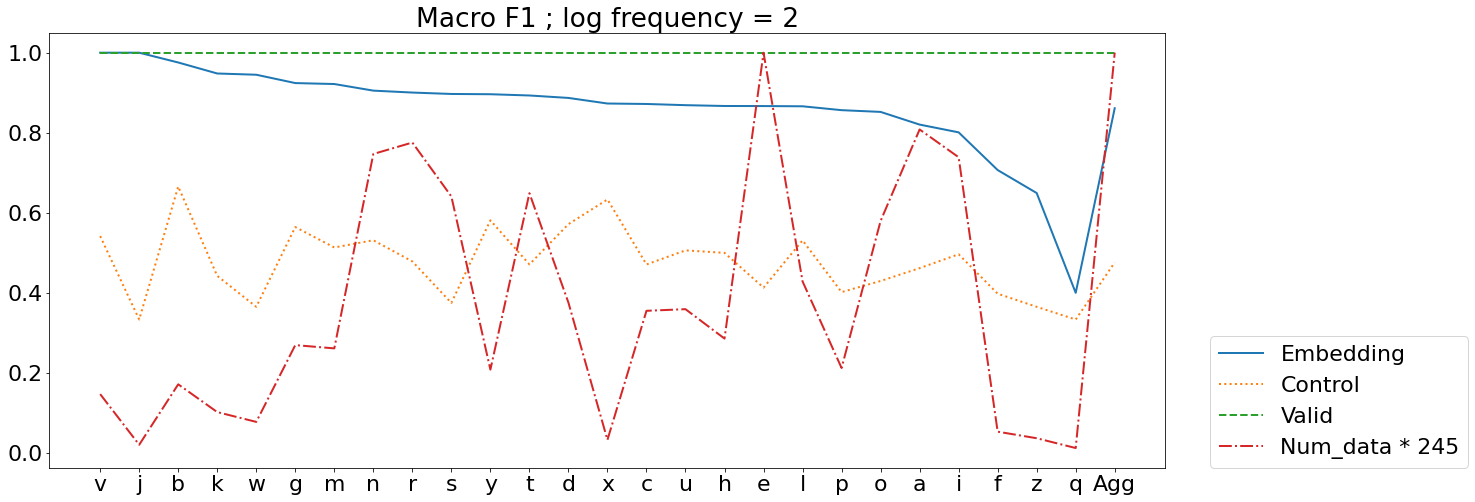

this_f1 {'a': 89.99, 'b': 90.75, 'c': 86.5, 'd': 89.17, 'e': 89.68, 'f': 96.29, 'g': 91.88, 'h': 86.77, 'i': 86.91, 'j': 50.0, 'k': 91.99, 'l': 90.37, 'm': 89.42, 'n': 90.04, 'o': 86.78, 'p': 89.19, 'q': 95.37, 'r': 90.63, 's': 92.0, 't': 87.59, 'u': 85.54, 'v': 89.1, 'w': 92.37, 'x': 83.03, 'y': 88.96, 'z': 93.28}

control_f1 {'a': 51.61, 'b': 58.12, 'c': 45.68, 'd': 53.6, 'e': 53.46, 'f': 56.43, 'g': 43.77, 'h': 49.83, 'i': 47.16, 'j': 14.29, 'k': 46.67, 'l': 49.45, 'm': 54.54, 'n': 49.71, 'o': 47.99, 'p': 53.37, 'q': 53.33, 'r': 50.35, 's': 47.96, 't': 48.97, 'u': 51.41, 'v': 44.65, 'w': 51.09, 'x': 48.57, 'y': 55.42, 'z': 60.8}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 612, 'b': 119, 'c': 304, 'd': 277, 'e': 775, 'f': 81, 'g': 197, 'h': 196, 'i': 596, 'j': 7, 'k': 75, 'l': 374, 'm': 208, 'n': 54

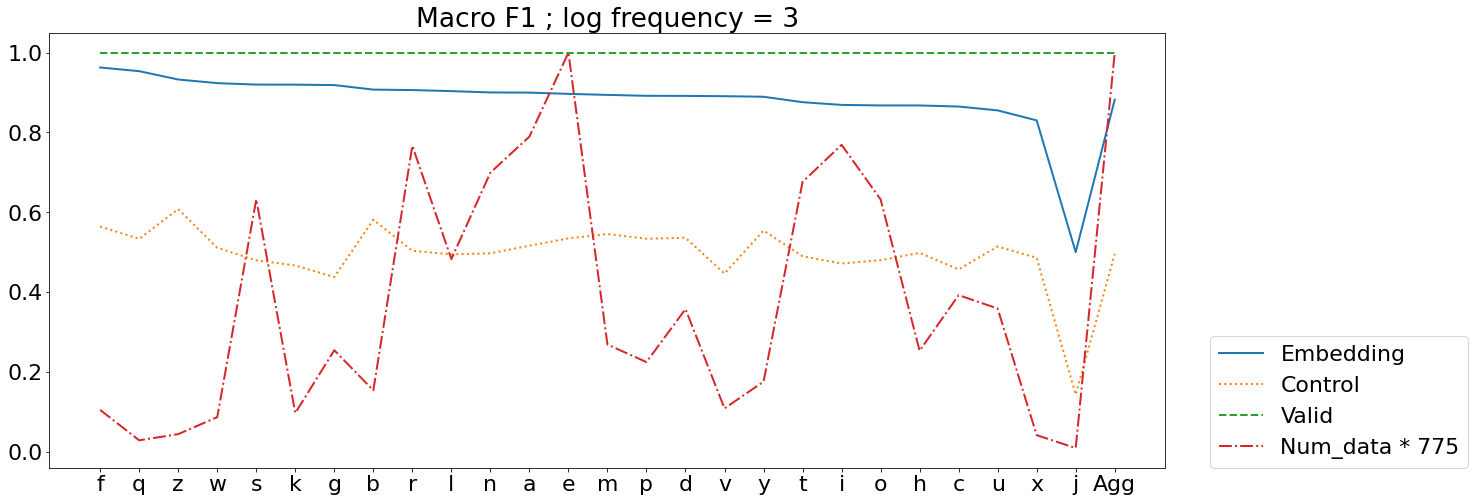

this_f1 {'a': 87.64, 'b': 90.26, 'c': 84.91, 'd': 88.56, 'e': 86.35, 'f': 96.31, 'g': 88.6, 'h': 89.99, 'i': 88.18, 'j': 97.97, 'k': 90.5, 'l': 91.8, 'm': 91.15, 'n': 87.9, 'o': 86.55, 'p': 92.27, 'q': 98.51, 'r': 90.33, 's': 89.96, 't': 89.87, 'u': 83.74, 'v': 89.64, 'w': 92.66, 'x': 93.0, 'y': 87.95, 'z': 87.93}

control_f1 {'a': 48.51, 'b': 45.9, 'c': 49.25, 'd': 50.95, 'e': 49.02, 'f': 52.15, 'g': 49.84, 'h': 50.21, 'i': 49.42, 'j': 37.5, 'k': 52.92, 'l': 49.36, 'm': 48.86, 'n': 49.98, 'o': 50.82, 'p': 48.01, 'q': 35.19, 'r': 48.46, 's': 50.83, 't': 51.11, 'u': 46.57, 'v': 50.61, 'w': 46.7, 'x': 48.25, 'y': 46.36, 'z': 37.34}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 2662, 'b': 530, 'c': 1208, 'd': 1198, 'e': 3330, 'f': 380, 'g': 798, 'h': 820, 'i': 2543, 'j': 53, 'k': 365, 'l': 1565, 'm': 876, 

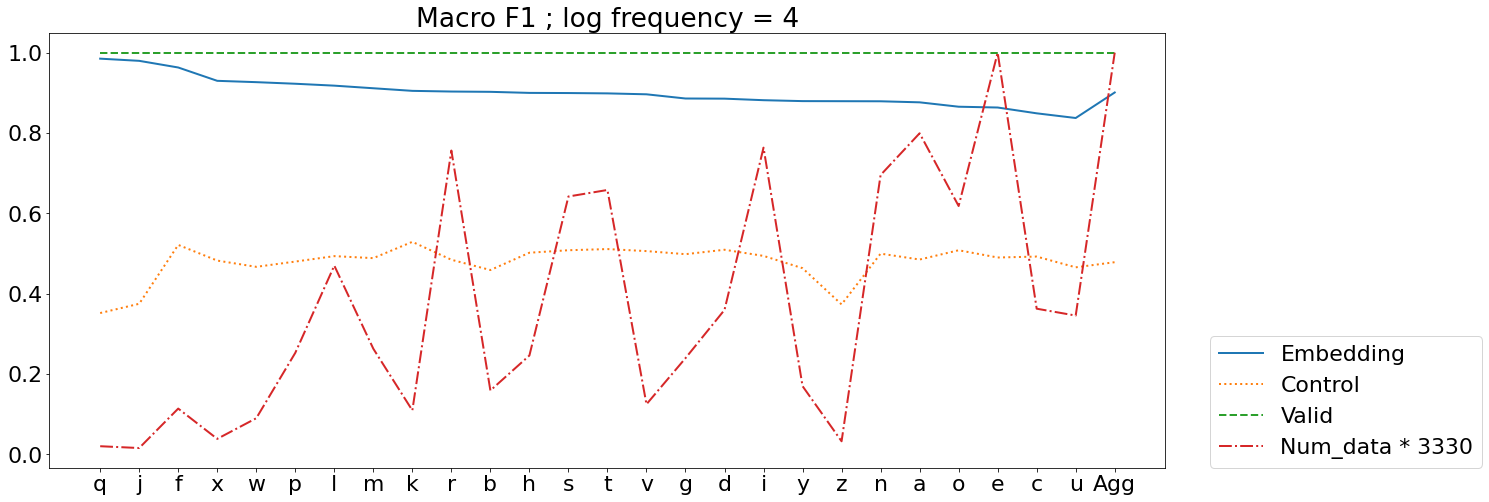

this_f1 {'a': 85.56, 'b': 91.2, 'c': 86.43, 'd': 88.64, 'e': 86.36, 'f': 92.73, 'g': 88.57, 'h': 88.61, 'i': 87.81, 'j': 97.16, 'k': 92.82, 'l': 90.74, 'm': 91.2, 'n': 88.69, 'o': 86.65, 'p': 90.91, 'q': 96.05, 'r': 89.8, 's': 90.09, 't': 88.99, 'u': 84.04, 'v': 90.04, 'w': 94.23, 'x': 94.17, 'y': 90.91, 'z': 93.83}

control_f1 {'a': 50.16, 'b': 49.22, 'c': 48.9, 'd': 49.94, 'e': 49.97, 'f': 48.38, 'g': 50.58, 'h': 48.69, 'i': 49.95, 'j': 48.75, 'k': 49.93, 'l': 49.75, 'm': 49.06, 'n': 50.51, 'o': 49.43, 'p': 50.03, 'q': 44.65, 'r': 49.98, 's': 49.45, 't': 50.06, 'u': 48.49, 'v': 49.91, 'w': 49.76, 'x': 47.52, 'y': 51.05, 'z': 45.64}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 9507, 'b': 1962, 'c': 4768, 'd': 4526, 'e': 11945, 'f': 1376, 'g': 3406, 'h': 3013, 'i': 9343, 'j': 176, 'k': 1254, 'l': 5912,

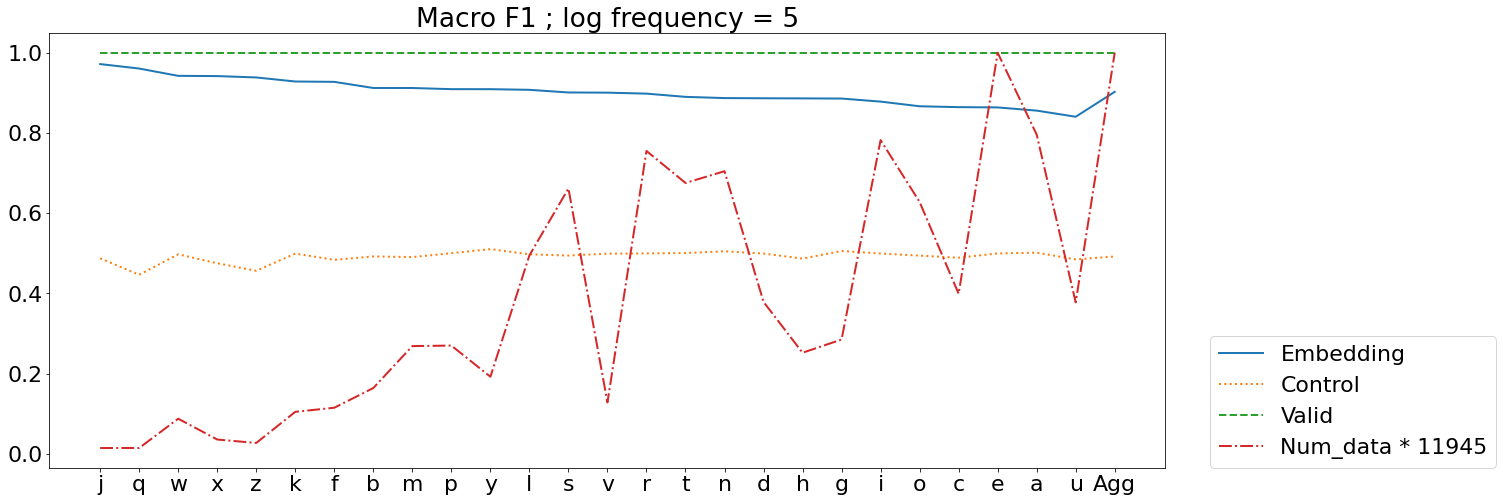

this_f1 {'a': 86.02, 'b': 91.37, 'c': 86.82, 'd': 88.58, 'e': 87.17, 'f': 94.13, 'g': 89.06, 'h': 89.41, 'i': 88.07, 'j': 92.84, 'k': 93.45, 'l': 90.1, 'm': 92.47, 'n': 87.93, 'o': 85.77, 'p': 91.29, 'q': 93.08, 'r': 89.35, 's': 90.39, 't': 88.69, 'u': 83.99, 'v': 89.27, 'w': 95.37, 'x': 96.24, 'y': 91.88, 'z': 95.05}

control_f1 {'a': 50.85, 'b': 51.08, 'c': 49.04, 'd': 50.42, 'e': 50.41, 'f': 50.79, 'g': 49.65, 'h': 48.47, 'i': 49.45, 'j': 46.84, 'k': 50.26, 'l': 50.43, 'm': 50.48, 'n': 50.81, 'o': 51.09, 'p': 51.18, 'q': 50.47, 'r': 48.95, 's': 50.25, 't': 49.11, 'u': 51.45, 'v': 47.44, 'w': 47.78, 'x': 52.61, 'y': 48.54, 'z': 46.15}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 10735, 'b': 2088, 'c': 5458, 'd': 5063, 'e': 13537, 'f': 1620, 'g': 3694, 'h': 3252, 'i': 10472, 'j': 224, 'k': 1252, 'l': 

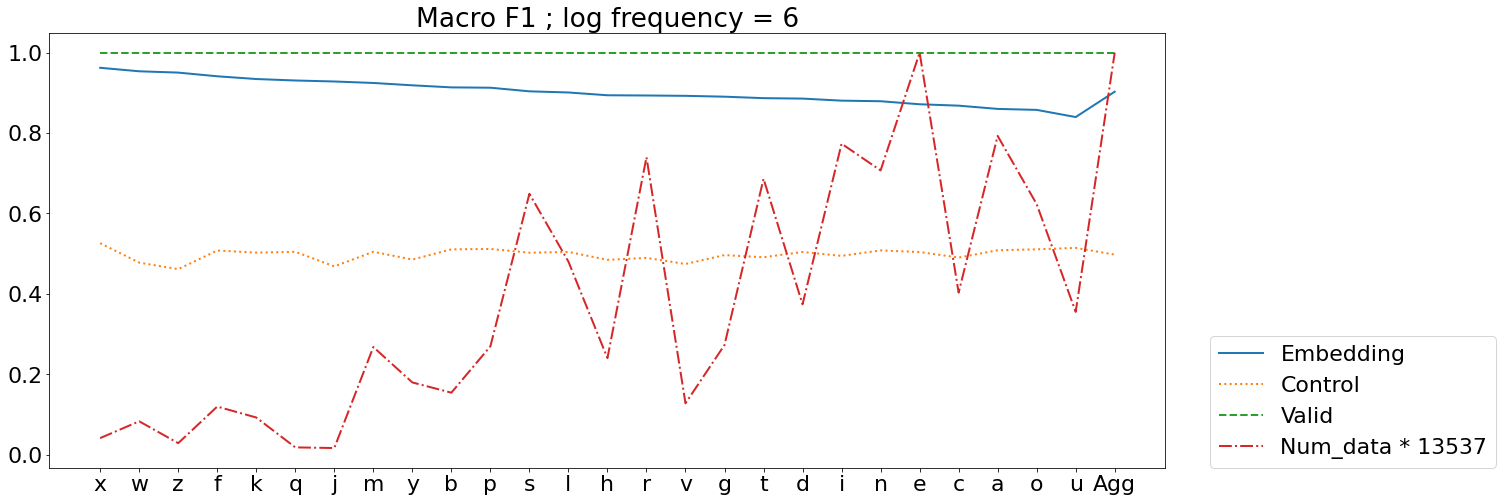

this_f1 {'a': 86.04, 'b': 90.42, 'c': 86.67, 'd': 88.81, 'e': 85.96, 'f': 94.45, 'g': 88.07, 'h': 89.55, 'i': 87.9, 'j': 94.95, 'k': 94.38, 'l': 89.18, 'm': 92.6, 'n': 88.23, 'o': 86.04, 'p': 91.56, 'q': 96.18, 'r': 87.73, 's': 90.74, 't': 89.02, 'u': 82.4, 'v': 89.67, 'w': 96.06, 'x': 94.3, 'y': 90.17, 'z': 90.92}

control_f1 {'a': 49.93, 'b': 51.55, 'c': 51.43, 'd': 52.24, 'e': 50.03, 'f': 48.44, 'g': 51.94, 'h': 51.23, 'i': 50.12, 'j': 47.06, 'k': 50.82, 'l': 51.88, 'm': 49.25, 'n': 50.24, 'o': 50.52, 'p': 50.4, 'q': 43.62, 'r': 49.22, 's': 48.92, 't': 50.19, 'u': 50.61, 'v': 50.2, 'w': 48.57, 'x': 49.77, 'y': 50.1, 'z': 54.84}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 6947, 'b': 1420, 'c': 3690, 'd': 3326, 'e': 8880, 'f': 1120, 'g': 2406, 'h': 2059, 'i': 6839, 'j': 163, 'k': 838, 'l': 4266, 'm':

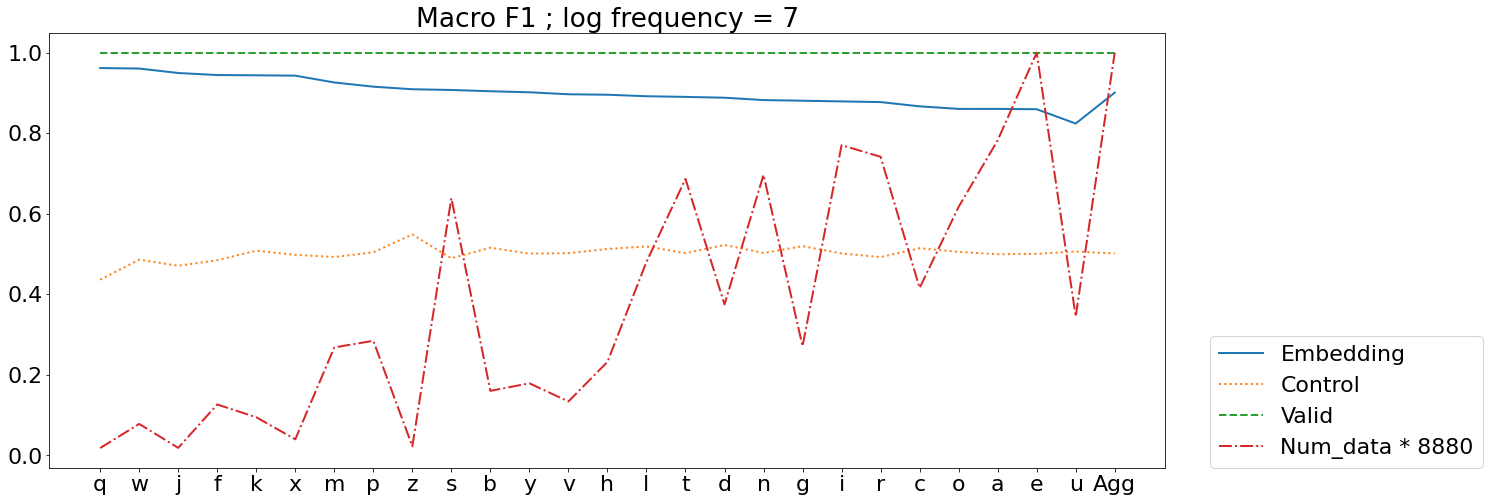

this_f1 {'a': 84.99, 'b': 89.56, 'c': 87.34, 'd': 86.84, 'e': 85.91, 'f': 92.79, 'g': 87.23, 'h': 89.95, 'i': 87.58, 'j': 92.86, 'k': 97.06, 'l': 88.81, 'm': 92.23, 'n': 86.34, 'o': 85.16, 'p': 90.75, 'q': 88.34, 'r': 87.44, 's': 89.6, 't': 87.65, 'u': 82.77, 'v': 90.26, 'w': 94.25, 'x': 92.82, 'y': 88.81, 'z': 96.95}

control_f1 {'a': 48.66, 'b': 50.26, 'c': 50.68, 'd': 50.31, 'e': 48.88, 'f': 55.51, 'g': 49.89, 'h': 51.75, 'i': 49.06, 'j': 52.88, 'k': 48.33, 'l': 50.65, 'm': 49.15, 'n': 50.32, 'o': 47.3, 'p': 53.4, 'q': 51.99, 'r': 50.93, 's': 51.12, 't': 49.45, 'u': 50.39, 'v': 51.82, 'w': 50.04, 'x': 53.92, 'y': 52.44, 'z': 55.16}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 3527, 'b': 675, 'c': 1819, 'd': 1788, 'e': 4598, 'f': 583, 'g': 1183, 'h': 1035, 'i': 3487, 'j': 84, 'k': 414, 'l': 2160, 'm'

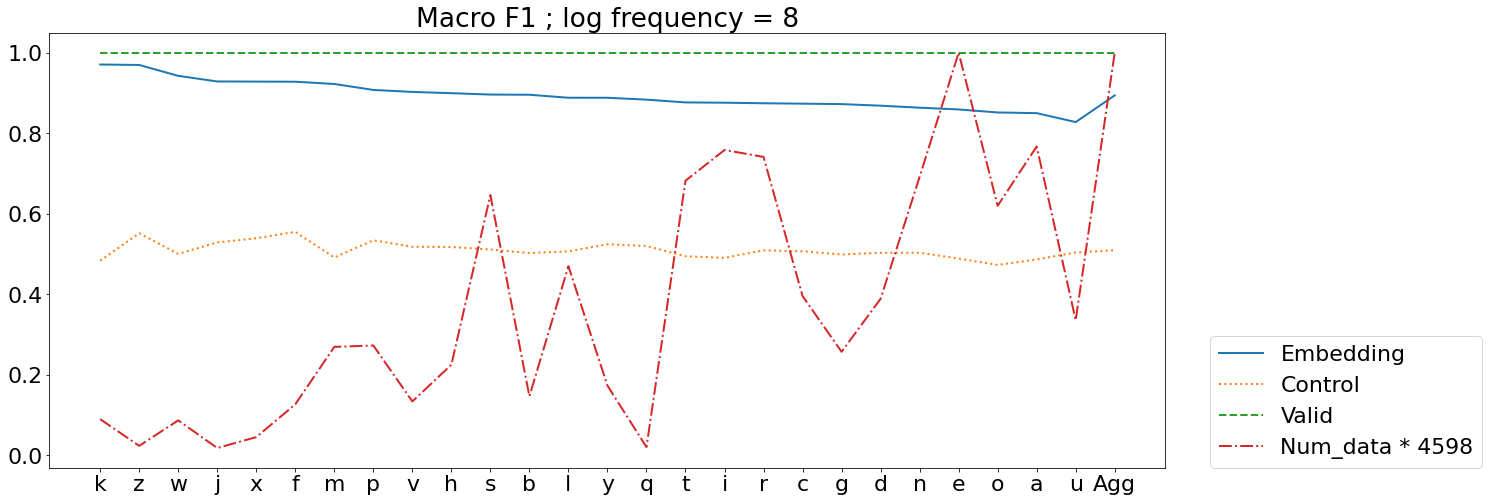

this_f1 {'a': 83.61, 'b': 87.42, 'c': 86.51, 'd': 86.58, 'e': 83.08, 'f': 90.65, 'g': 84.28, 'h': 88.42, 'i': 84.55, 'j': 88.57, 'k': 96.3, 'l': 86.25, 'm': 91.66, 'n': 84.68, 'o': 85.11, 'p': 91.88, 'q': 95.8, 'r': 86.58, 's': 90.05, 't': 85.62, 'u': 80.09, 'v': 85.37, 'w': 94.35, 'x': 96.82, 'y': 90.48, 'z': 100.0}

control_f1 {'a': 50.08, 'b': 54.01, 'c': 48.32, 'd': 49.9, 'e': 47.46, 'f': 53.58, 'g': 48.48, 'h': 53.99, 'i': 50.59, 'j': 35.76, 'k': 50.73, 'l': 49.18, 'm': 46.51, 'n': 51.5, 'o': 51.18, 'p': 47.3, 'q': 26.67, 'r': 49.21, 's': 49.52, 't': 51.91, 'u': 45.88, 'v': 49.25, 'w': 50.15, 'x': 53.57, 'y': 44.88, 'z': 44.59}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 1510, 'b': 288, 'c': 742, 'd': 716, 'e': 1945, 'f': 258, 'g': 484, 'h': 446, 'i': 1467, 'j': 36, 'k': 150, 'l': 892, 'm': 516, 

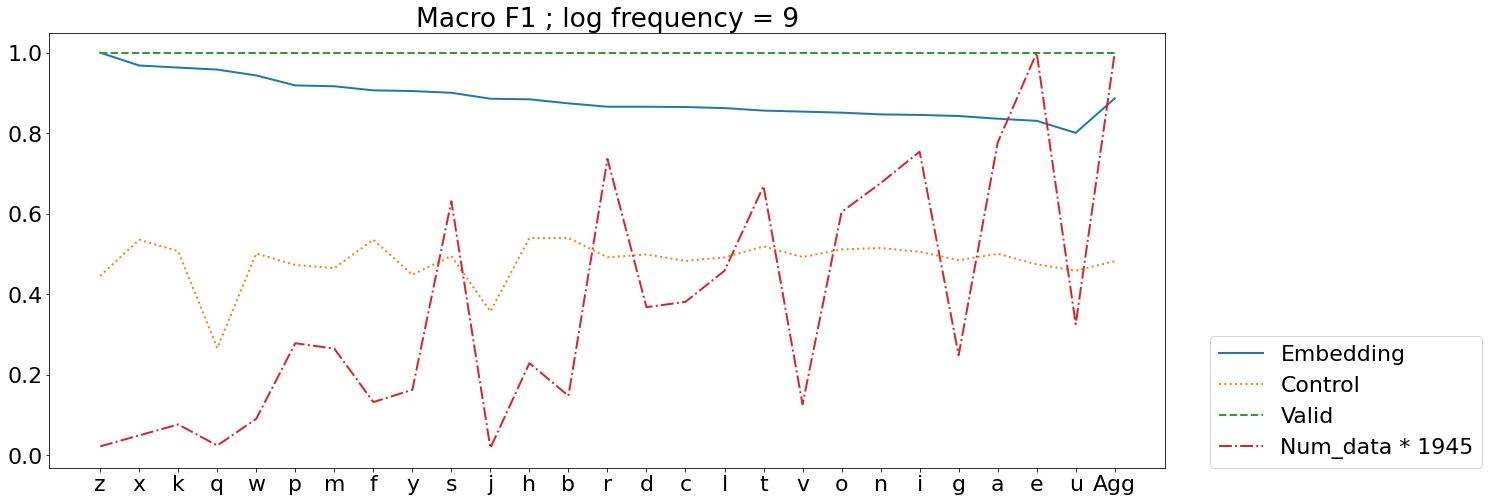

this_f1 {'a': 85.07, 'b': 92.82, 'c': 88.51, 'd': 88.67, 'e': 85.48, 'f': 82.62, 'g': 83.73, 'h': 90.95, 'i': 83.64, 'j': 92.82, 'k': 95.05, 'l': 86.12, 'm': 93.45, 'n': 83.47, 'o': 84.44, 'p': 91.18, 'q': 85.42, 'r': 86.18, 's': 88.0, 't': 87.86, 'u': 79.49, 'v': 88.23, 'w': 92.71, 'x': 82.64, 'y': 88.62, 'z': 100.0}

control_f1 {'a': 50.68, 'b': 45.97, 'c': 50.17, 'd': 44.79, 'e': 48.37, 'f': 49.99, 'g': 49.09, 'h': 45.75, 'i': 49.56, 'j': 57.14, 'k': 43.24, 'l': 46.49, 'm': 42.34, 'n': 51.34, 'o': 48.73, 'p': 46.61, 'q': 53.33, 'r': 51.73, 's': 48.72, 't': 50.14, 'u': 51.52, 'v': 45.58, 'w': 43.79, 'x': 42.69, 'y': 47.38, 'z': 27.27}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 489, 'b': 98, 'c': 219, 'd': 201, 'e': 614, 'f': 75, 'g': 151, 'h': 147, 'i': 476, 'j': 14, 'k': 46, 'l': 291, 'm': 168, 'n

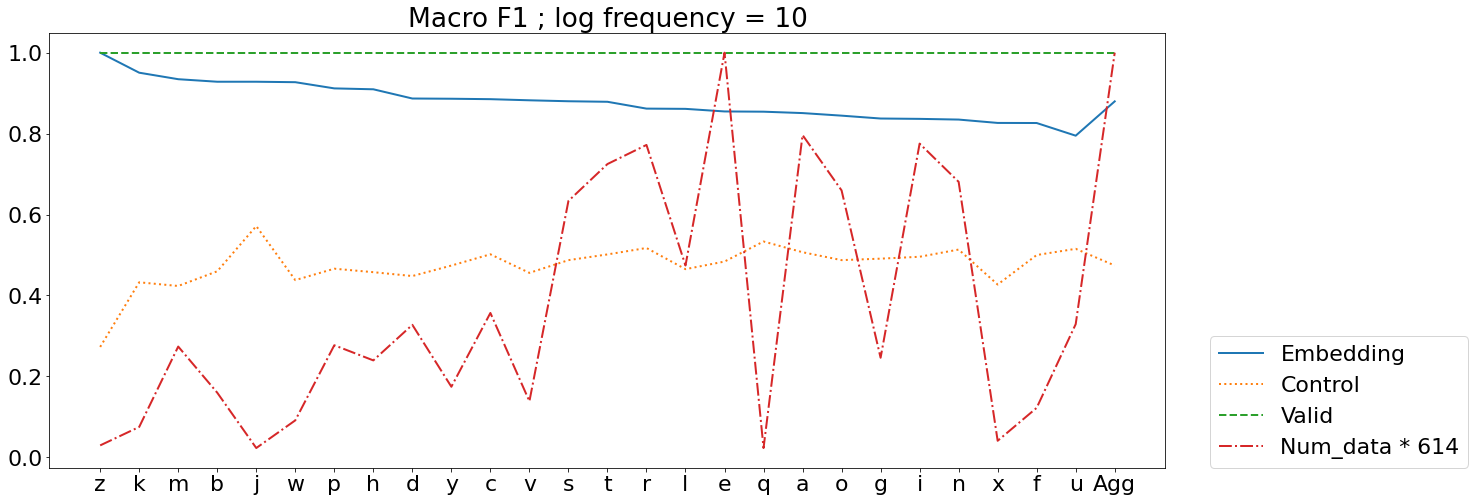

this_f1 {'a': 75.81, 'b': 84.18, 'c': 73.93, 'd': 92.51, 'e': 87.38, 'f': 89.27, 'g': 81.05, 'h': 81.13, 'i': 80.82, 'j': 0.0, 'k': 100.0, 'l': 95.62, 'm': 97.91, 'n': 83.78, 'o': 82.44, 'p': 95.41, 'q': 0.0, 'r': 83.57, 's': 93.42, 't': 82.51, 'u': 83.57, 'v': 100.0, 'w': 100.0, 'x': 50.0, 'y': 69.14, 'z': 0.0}

control_f1 {'a': 45.57, 'b': 39.79, 'c': 30.16, 'd': 40.86, 'e': 48.78, 'f': 45.82, 'g': 49.27, 'h': 56.16, 'i': 46.63, 'j': 0.0, 'k': 41.26, 'l': 49.21, 'm': 47.96, 'n': 49.78, 'o': 44.11, 'p': 37.73, 'q': 50.0, 'r': 45.69, 's': 50.98, 't': 42.94, 'u': 47.69, 'v': 52.0, 'w': 46.43, 'x': 28.57, 'y': 40.0, 'z': 40.0}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 155, 'b': 24, 'c': 61, 'd': 70, 'e': 203, 'f': 28, 'g': 47, 'h': 49, 'i': 146, 'j': 0, 'k': 16, 'l': 76, 'm': 48, 'n': 141, 'o': 118, '

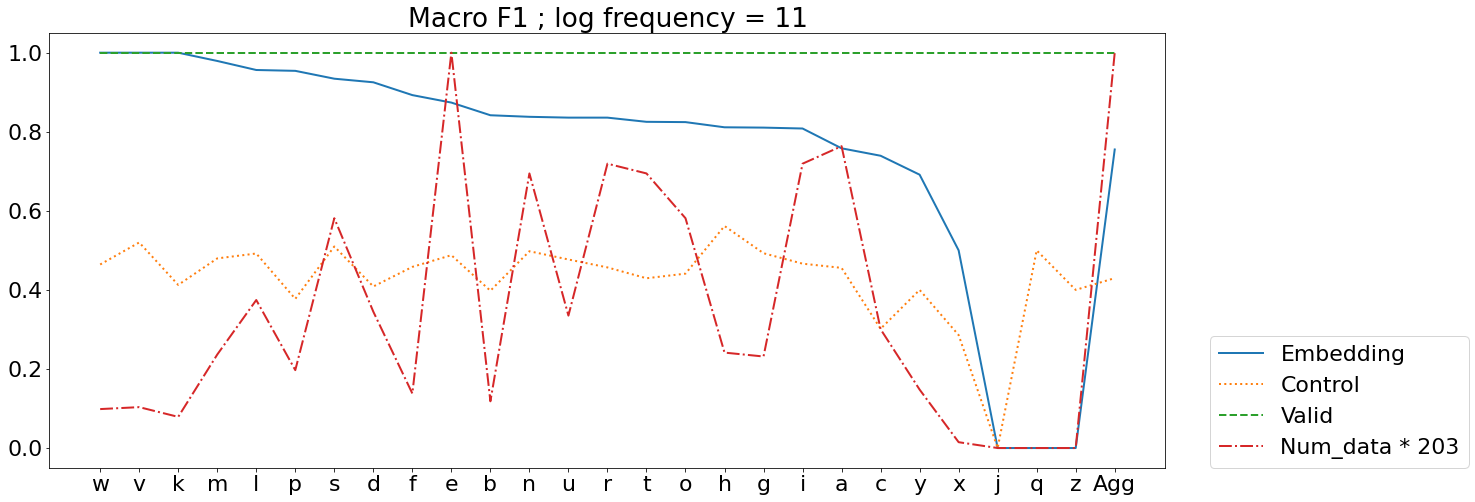

this_f1 {'a': 91.48, 'b': 53.33, 'c': 80.95, 'd': 70.0, 'e': 67.63, 'f': 50.0, 'g': 50.0, 'h': 93.84, 'i': 86.36, 'j': 0.0, 'k': 66.67, 'l': 89.2, 'm': 89.92, 'n': 89.17, 'o': 82.24, 'p': 100.0, 'q': 50.0, 'r': 100.0, 's': 78.54, 't': 84.24, 'u': 76.62, 'v': 50.0, 'w': 79.49, 'x': 50.0, 'y': 66.67, 'z': 50.0}

control_f1 {'a': 49.32, 'b': 25.0, 'c': 30.77, 'd': 30.77, 'e': 39.34, 'f': 50.0, 'g': 42.86, 'h': 35.69, 'i': 42.71, 'j': 0.0, 'k': 0.0, 'l': 41.07, 'm': 66.67, 'n': 42.42, 'o': 49.9, 'p': 42.86, 'q': 0.0, 'r': 51.93, 's': 57.86, 't': 47.73, 'u': 61.9, 'v': 0.0, 'w': 20.0, 'x': 0.0, 'y': 62.5, 'z': 50.0}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 0, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 0, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 30, 'b': 7, 'c': 12, 'd': 12, 'e': 44, 'f': 3, 'g': 9, 'h': 21, 'i': 33, 'j': 0, 'k': 3, 'l': 19, 'm': 12, 'n': 26, 'o': 27, 'p': 10, 'q': 1, 'r': 31

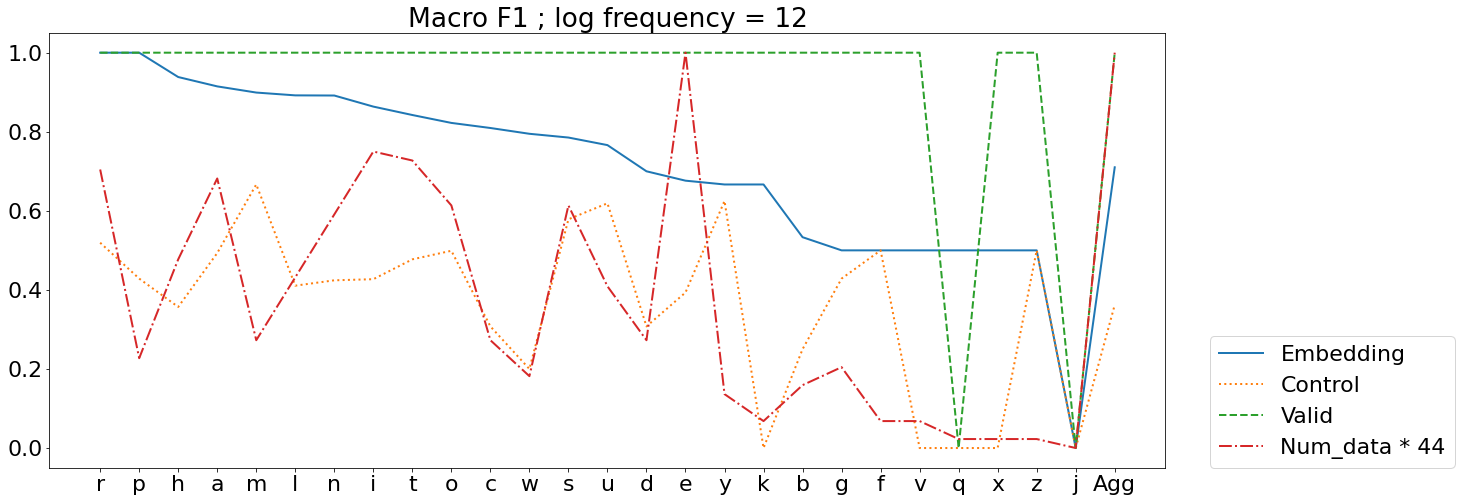

this_f1 {'a': 81.94, 'b': 100.0, 'c': 50.0, 'd': 50.0, 'e': 72.06, 'f': 25.0, 'g': 33.33, 'h': 65.0, 'i': 91.61, 'j': 50.0, 'k': 50.0, 'l': 50.0, 'm': 100.0, 'n': 89.01, 'o': 90.6, 'p': 50.0, 'q': 50.0, 'r': 68.75, 's': 79.17, 't': 91.61, 'u': 42.86, 'v': 73.33, 'w': 28.57, 'x': 50.0, 'y': 100.0, 'z': 50.0}

control_f1 {'a': 49.76, 'b': 50.0, 'c': 20.0, 'd': 33.33, 'e': 41.46, 'f': 100.0, 'g': 33.33, 'h': 48.57, 'i': 54.54, 'j': 0.0, 'k': 0.0, 'l': 37.5, 'm': 50.0, 'n': 52.99, 'o': 89.9, 'p': 0.0, 'q': 50.0, 'r': 35.0, 's': 60.0, 't': 58.33, 'u': 42.86, 'v': 25.0, 'w': 42.86, 'x': 0.0, 'y': 100.0, 'z': 50.0}

valid {'a': 1, 'b': 1, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 1, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 1, 'w': 1, 'x': 1, 'y': 1, 'z': 1}

num_data {'a': 13, 'b': 3, 'c': 4, 'd': 4, 'e': 19, 'f': 3, 'g': 2, 'h': 7, 'i': 12, 'j': 1, 'k': 2, 'l': 5, 'm': 3, 'n': 10, 'o': 11, 'p': 2, 'q': 1, 'r': 10, 's': 10

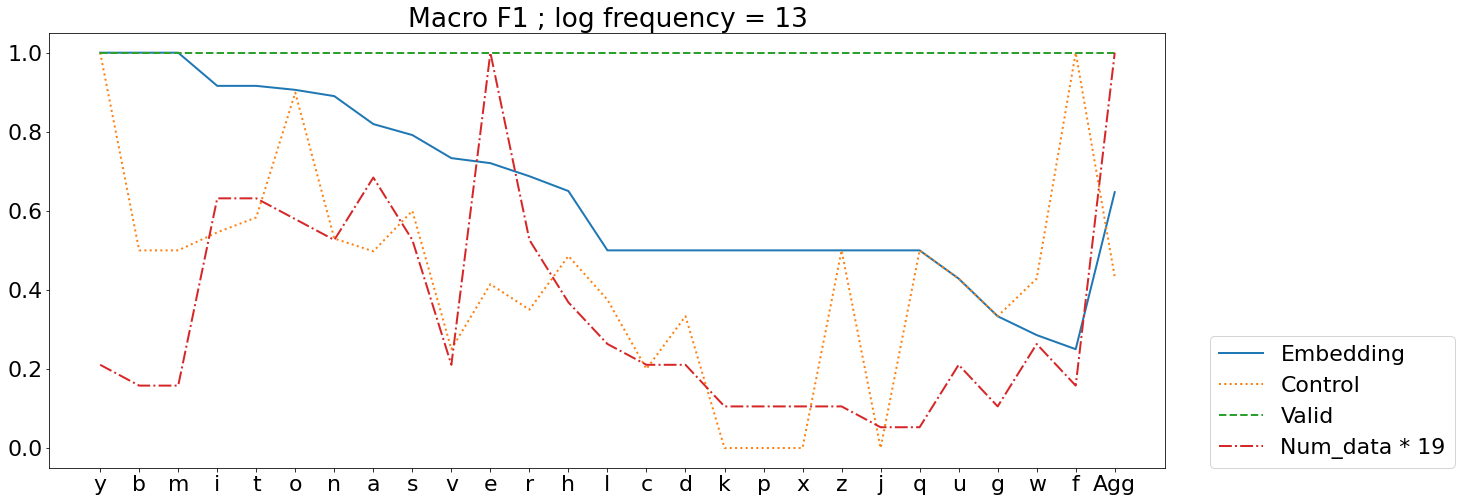

this_f1 {'a': 33.33, 'b': 0.0, 'c': 50.0, 'd': 25.0, 'e': 100.0, 'f': 0.0, 'g': 0.0, 'h': 0.0, 'i': 100.0, 'j': 0.0, 'k': 0.0, 'l': 50.0, 'm': 0.0, 'n': 30.0, 'o': 80.0, 'p': 0.0, 'q': 0.0, 'r': 45.45, 's': 50.0, 't': 76.19, 'u': 50.0, 'v': 0.0, 'w': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0}

control_f1 {'a': 48.57, 'b': 0.0, 'c': 50.0, 'd': 25.0, 'e': 38.46, 'f': 33.33, 'g': 0.0, 'h': 0.0, 'i': 33.33, 'j': 0.0, 'k': 0.0, 'l': 50.0, 'm': 50.0, 'n': 0.0, 'o': 33.33, 'p': 50.0, 'q': 0.0, 'r': 73.33, 's': 25.0, 't': 28.57, 'u': 50.0, 'v': 0.0, 'w': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0}

valid {'a': 1, 'b': 0, 'c': 1, 'd': 1, 'e': 1, 'f': 1, 'g': 1, 'h': 1, 'i': 1, 'j': 0, 'k': 0, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 0, 'r': 1, 's': 1, 't': 1, 'u': 1, 'v': 0, 'w': 0, 'x': 0, 'y': 0, 'z': 0}

num_data {'a': 8, 'b': 0, 'c': 1, 'd': 3, 'e': 9, 'f': 2, 'g': 0, 'h': 1, 'i': 6, 'j': 0, 'k': 0, 'l': 1, 'm': 0, 'n': 7, 'o': 5, 'p': 0, 'q': 0, 'r': 6, 's': 4, 't': 5, 'u': 1, 'v': 0, 'w': 0, 'x': 0, '

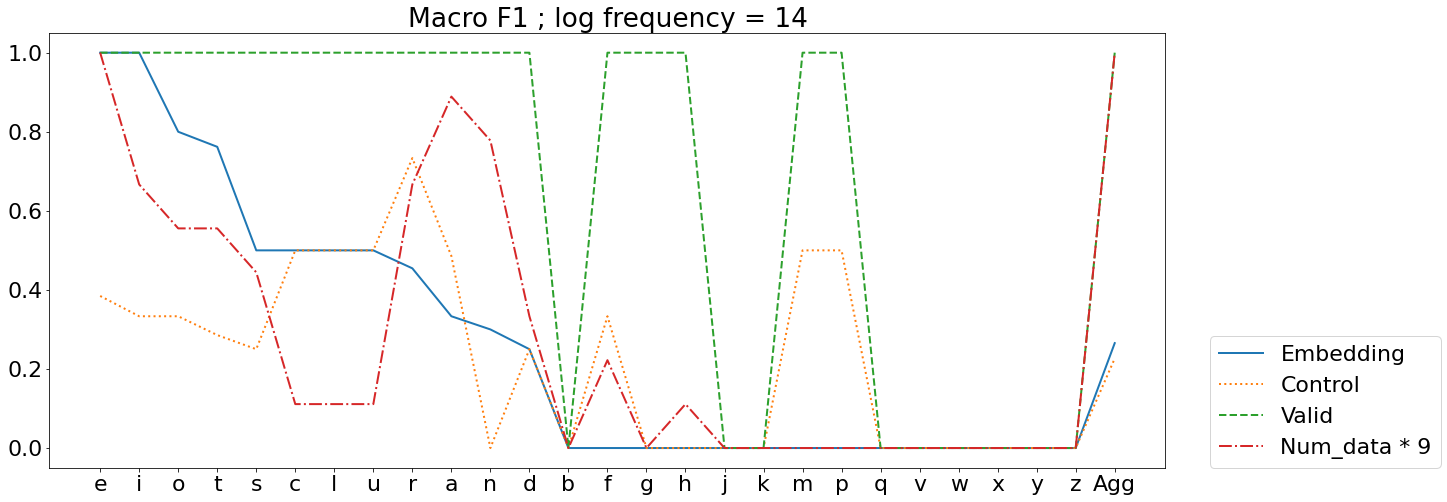

In [15]:
sort = True
sort_by = 1

for l in range(2, max_len):
    print("this_f1", {c: round(this_f1[c][l]*100, 2) for c in string.ascii_lowercase})
    print()
    print("control_f1", {c: round(control_f1[c][l]*100, 2) for c in string.ascii_lowercase})
    print()
    print("valid", {c: valid[c][l] for c in string.ascii_lowercase})
    print()
    print("num_data", {c: num_data[c][l] for c in string.ascii_lowercase})
    print()
    print("tp", {c: (tp_num[c][l], tp_eg[c][l]) for c in string.ascii_lowercase})
    print()
    print("tn", {c: (tn_num[c][l], tn_eg[c][l]) for c in string.ascii_lowercase})
    print()
    print("fp", {c: (fp_num[c][l], fp_eg[c][l]) for c in string.ascii_lowercase})
    print()
    print("fn", {c: (fn_num[c][l], fn_eg[c][l]) for c in string.ascii_lowercase})
    print()

    this_f1_l    = [x[l] for x in this_f1.values()]
    ctrl_f1_l = [x[l] for x in control_f1.values()]
    valid_l      = [x[l] for x in valid.values()]
    num_data_l_o   = [x[l] for x in num_data.values()]
    num_data_l   = [x/max(1, max(num_data_l_o)) for x in num_data_l_o]

    sorted_indices = sorted(list(range(len(this_f1_l))), key = lambda x: -this_f1_l[x])
    sort_it = lambda x: x
    if sort == False:
        sorted_indices = list(range(len(this_f1_l)))
    elif sort_by == 1:
        sort_it = lambda x: [x[y] for y in sorted_indices]
    else:
        sorted_indices = sorted(list(range(len(num_data_l))), key = lambda x: -num_data_l[x])
        sort_it = lambda x: [x[y] for y in sorted_indices]

    fig, ax = plt.subplots()
    plt.plot(sort_it(this_f1_l) + [sum(this_f1_l)/len(this_f1_l)], linestyle='-' , linewidth=2, label='Embedding')
    plt.plot(sort_it(ctrl_f1_l) + [sum(ctrl_f1_l)/len(ctrl_f1_l)], linestyle=':' , linewidth=2, label='Control')
    plt.plot(sort_it(valid_l) + [max(valid_l)], linestyle='--' , linewidth=2, label='Valid')
    plt.plot(sort_it(num_data_l) + [max(num_data_l)], linestyle='-.' , linewidth=2, label='Num_data * ' + str(max(num_data_l_o)))
    # ax.plot([3,3.1,3,3.1,3], linestyle='-.' , linewidth=4, label='3')
    # ax.plot([4,4.1,4,4.1,4], linestyle=':' , linewidth=4, label='1')
    ax.set_xticks(range(0,27))
    ax.set_xticklabels(sort_it(list(string.ascii_lowercase)) + ['Agg'])

    # plt.axis('off')
    plt.title('Macro F1 ; log frequency = ' + str(l))
    plt.legend(loc=(1.04,0))
    plt.show()


In [16]:
mean = lambda x: sum(x)/len(x)

headers = ['length', 'gptj_f1', "control_f1", 'num_data']
rows = []
for l in range(max_len):
    f1_aggr = sum(this_f1[c][l] for c in string.ascii_lowercase)/(sum([num_data[c][l] != 0 for c in string.ascii_lowercase])+0.000001)
    ctrl_aggr = sum(control_f1[c][l] for c in string.ascii_lowercase)/(sum([num_data[c][l] != 0 for c in string.ascii_lowercase])+0.000001)
    num_data_aggr = sum(num_data[c][l] for c in string.ascii_lowercase)
    rows.append([l] + [f1_aggr, ctrl_aggr, num_data_aggr])
rows = [headers] + rows


In [17]:
open('performance_vs_token_frequency.csv' ,'w+').write('\n'.join([','.join([str(cell) for cell in row]) for row in rows]))

723